# Convert tiffs to eopatches

```
#
# Copyright (c) Sinergise, 2019 -- 2021.
#
# This file belongs to subproject "field-delineation" of project NIVA (www.niva4cap.eu).
# All rights reserved.
#
# This source code is licensed under the MIT license found in the LICENSE
# file in the root directory of this source tree.
#
```

The script converts tiffs downloaded using SentinelHUb's batch API to eopatches.

In [1]:
from pathlib import Path

from typing import Callable, List, Any

import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from eolearn.core import EOPatch, EOExecutor

In [2]:
from fd.tiffs_to_eopatch import (
    TiffsToEopatchConfig,
    get_tiffs_to_eopatches_workflow,
    get_exec_args)

from fd.utils import prepare_filesystem

### Constants

In [3]:
INPUT_DATA_DIR = Path('../../input-data/')

In [4]:
tiffs_to_eops_config = TiffsToEopatchConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    tiffs_folder='data/Castilla/2020-04/tiffs',
    eopatches_folder='data/Castilla/2020-04/eopatches',
    band_names=['B02', 'B03', 'B04', 'B08'],
    mask_name='dataMask',
    clp_name='CLP',
    clm_name='CLM'
)

### Load tile definition derived from the batch process API

In [5]:
grid_definition = gpd.read_file(INPUT_DATA_DIR/'cyl-grid-definition.gpkg')
grid_definition.head()

,id,name,geometry
0,2302137,30TVM_2_5,"POLYGON ((-3.96458 41.90790, -3.96594 41.99795..."
1,2301391,30TUN_7_8,"POLYGON ((-4.58294 42.53146, -4.58522 42.62148..."
2,2301392,30TUN_7_9,"POLYGON ((-4.58067 42.44143, -4.58294 42.53146..."
3,2301398,30TUN_8_5,"POLYGON ((-4.46755 42.80315, -4.46969 42.89318..."
4,2301399,30TUN_8_6,"POLYGON ((-4.46543 42.71313, -4.46755 42.80315..."


Import `eo-learn` workflow transforming the `.tif` files to `EOPatches`

In [6]:
workflow = get_tiffs_to_eopatches_workflow(tiffs_to_eops_config, delete_tiffs=False)

Build list of inputs for execution

In [7]:
eopatch_list = grid_definition.name.values

In [8]:
exec_args = get_exec_args(workflow, eopatch_list)

In [9]:
exec_args[0]

{<eolearn.io.local_io.ImportFromTiff at 0x7fe349fcec50>: {'filename': '30TVM_2_5/B02.tif'},
 <eolearn.io.local_io.ImportFromTiff at 0x7fe349fcedd8>: {'filename': '30TVM_2_5/B03.tif'},
 <eolearn.io.local_io.ImportFromTiff at 0x7fe349fceda0>: {'filename': '30TVM_2_5/B04.tif'},
 <eolearn.io.local_io.ImportFromTiff at 0x7fe349fcef28>: {'filename': '30TVM_2_5/B08.tif'},
 <eolearn.io.local_io.ImportFromTiff at 0x7fe349fcecf8>: {'filename': '30TVM_2_5/CLP.tif'},
 <eolearn.io.local_io.ImportFromTiff at 0x7fe349fd3080>: {'filename': '30TVM_2_5/dataMask.tif'},
 <fd.tiffs_to_eopatch.AddTimestampsUpdateTime at 0x7fe349fd3470>: {'tile_name': '30TVM_2_5'},
 <eolearn.core.core_tasks.SaveTask at 0x7fe3790c0668>: {'eopatch_folder': '30TVM_2_5'}}

Test workflow on a single eopatch

In [10]:
eop = workflow.execute(exec_args[0])
eop = list(eop.values())[0]

print(eop)
print(eop.timestamp)

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(11, 1100, 1100, 4), dtype=uint16)
    CLP: numpy.ndarray(shape=(11, 1100, 1100, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(11, 1100, 1100, 1), dtype=int8)
    IS_DATA: numpy.ndarray(shape=(11, 1100, 1100, 1), dtype=uint8)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((419500.0, 4639500.0), (430500.0, 4650500.0)), crs=CRS('32630'))
  timestamp: [datetime.datetime(2020, 3, 22, 0, 0, tzinfo=tzlocal()), ...], length=11
)
[datetime.datetime(2020, 3, 22, 0, 0, tzinfo=tzlocal()), datetime.datetime(2020, 3, 24, 0, 0, tzinfo=tzlocal()), datetime.datetime(2020, 3, 27, 0, 0, tzinfo=tzlocal()), datetime.datetime(2020, 3, 29, 0, 0, tzinfo=tzlocal()), datetime.datetime(2020, 4, 3, 0, 0, tzinfo=tzlocal()), datetime.datetime(2020, 4, 8, 0, 0, tzinfo=tzlocal()), datetime.datetime(2020, 4, 13, 0, 0, tzinfo=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


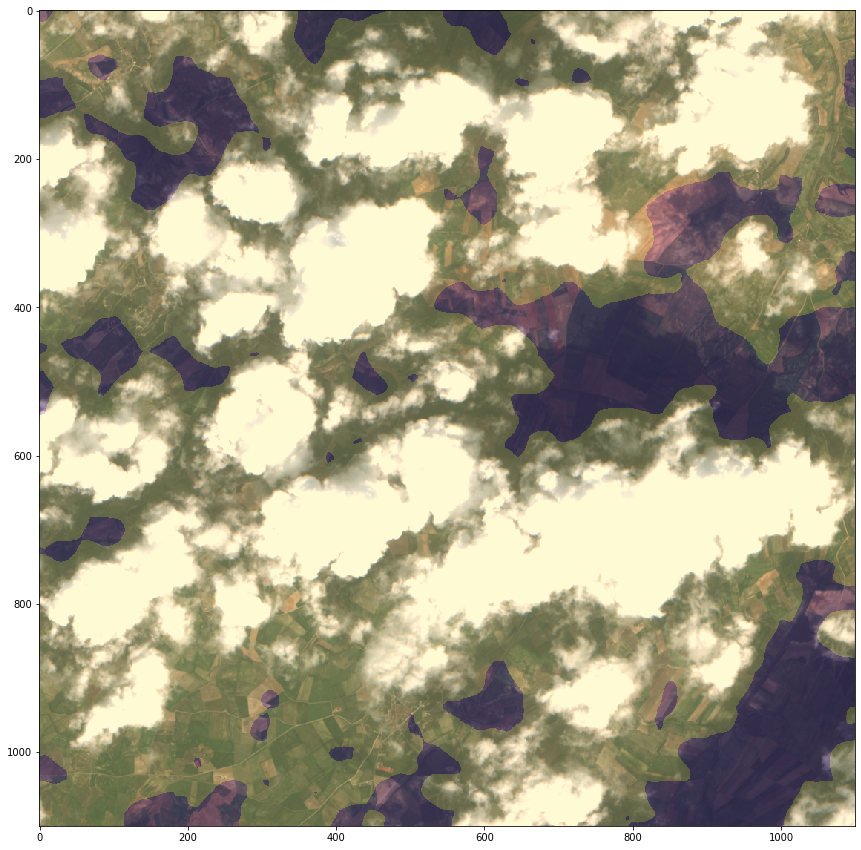

In [11]:
tidx = 0

plt.figure(figsize=(15,15))
plt.imshow(2.5*eop.data['BANDS'][tidx][..., [2,1,0]]/10000)
plt.imshow(eop.mask['CLM'][tidx][..., 0], vmin=0, vmax=1, alpha=.2)

Run on all eopatches in parallel

In [10]:
MAX_WORKERS = 24

executor = EOExecutor(workflow, exec_args, save_logs=True, logs_folder='.')

executor.run(workers=MAX_WORKERS)

In [11]:
%matplotlib

executor.make_report()

print('Report was saved to location: {}'.format(executor.get_report_filename()))

Using matplotlib backend: agg
Report was saved to location: ./eoexecution-report-2020_12_23-12_36_39/report.html
